In [1]:
%load_ext autoreload
%autoreload 2
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import sys
sys.path.insert(1, '../../SyMBac')
sys.path.insert(1, '../../single_cell_projection_diffraction/')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
from skimage.transform import rotate
from skimage.transform import rescale
import scienceplots
from seaborn import move_legend
from copy import deepcopy
plt.style.use('nature')

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from matplotlib.colors import LogNorm, AsinhNorm, PowerNorm
from SyMBac.drawing import raster_cell, convert_to_3D
from SyMBac.renderer import convolve_rescale, PSF_generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import cupy as cp
from cupyx.scipy.ndimage import convolve as cuconvolve
def convolve_rescale(image, kernel, rescale_factor, rescale_int):
    """
    Convolves an image with a kernel, and rescales it to the correct size.

    Parameters
    ----------
    image : 2D numpy array
        The image
    kernel : 2D numpy array
        The kernel
    rescale_factor : int
        Typicall 1/resize_amount. So 1/3 will scale the image down by a factor of 3. We do this because we render the image and kernel at high resolution, so that we can do the convolution at high resolution.
    rescale_int : bool
        If True, rescale the intensities between 0 and 1 and return a float32 numpy array of the convolved downscaled image.

    Returns
    -------
    outupt : 2D numpy array
        The output of the convolution rescale operation
    """

    output = cuconvolve(cp.array(image), cp.array(kernel),mode="constant")
    output = output.get()
    output = rescale(output, rescale_factor, anti_aliasing=False)

    if rescale_int:
        output = rescale_intensity(output.astype(np.float32), out_range=(0, 1))
    return output

In [3]:
def crop_to_size(arr, x, y):
    crop_x = arr.shape[1] - x
    crop_y = arr.shape[0] - y
    return arr[crop_y//2:-crop_y//2, crop_x//2:-crop_x//2]

size: 104


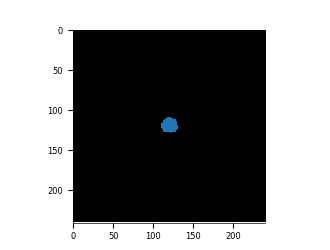

In [4]:
real_PSF = tifffile.imread("../../PSF_comparison/average_100x_PSF_postmag.tif").astype(np.float32)
label_image = cle.voronoi_otsu_labeling(real_PSF)
imshow(label_image, labels=True)
stats = cle.statistics_of_labelled_pixels(real_PSF, label_image)

df = pd.DataFrame(stats)
df[["mass_center_x", "mass_center_y", "mass_center_z"]]
pix_mic_conv = 0.05
#real_PSF = np.sum(real_PSF[int(df["mass_center_z"])-10:int(df["mass_center_z"])+10], axis = 0)
real_PSF = rescale(real_PSF, (0.05/pix_mic_conv, (0.0655/1.5) / pix_mic_conv, (0.0655/1.5) / pix_mic_conv) , anti_aliasing=True)
real_PSF -= real_PSF.min()
real_PSF = real_PSF / np.sum(real_PSF)



In [5]:
pix_mic_conreal_PSF = 0.05

In [6]:
x, y = 50, 50
zz = real_PSF[:-20].sum(axis=2)
crop_x = zz.shape[1] - x
crop_y = zz.shape[0] - y
print(crop_x, crop_y)
zz[crop_y//2:-crop_y//2, crop_x//2:-crop_x//2]


160 34


array([[5.1941741e-05, 5.2336065e-05, 5.2452015e-05, ..., 5.3044212e-05,
        5.2925308e-05, 5.2506482e-05],
       [5.1788462e-05, 5.1765423e-05, 5.2244010e-05, ..., 5.2984589e-05,
        5.2597177e-05, 5.2237905e-05],
       [5.1284849e-05, 5.1662719e-05, 5.1684205e-05, ..., 5.2518117e-05,
        5.2273823e-05, 5.1844767e-05],
       ...,
       [4.7553505e-05, 4.8514143e-05, 4.9626397e-05, ..., 5.0012455e-05,
        4.9400616e-05, 4.8616908e-05],
       [4.9173228e-05, 5.0072318e-05, 5.1028263e-05, ..., 5.0333416e-05,
        4.9916998e-05, 4.9165599e-05],
       [5.0849132e-05, 5.1479270e-05, 5.2001047e-05, ..., 5.0592367e-05,
        5.0132148e-05, 4.9925999e-05]], dtype=float32)

In [7]:
my_kernel = PSF_generator(
    radius = 150, 
    wavelength = 0.515, 
    NA=1.49, 
    n = 1.518, 
    resize_amount=1, 
    pix_mic_conv=pix_mic_conv, 
    apo_sigma = 10, 
    mode="3d fluo", 
    condenser="Ph3", 
    z_height = 151,
    pz = 0.5,
    working_distance = 170
)
my_kernel.calculate_PSF()
#my_kernel.kernel = np.sum(my_kernel.kernel, axis=0) # take the projection, it makes basically no difference compared to 3D convolution
my_kernel.kernel /= np.sum(my_kernel.kernel) # normalise so kernel sums to 1

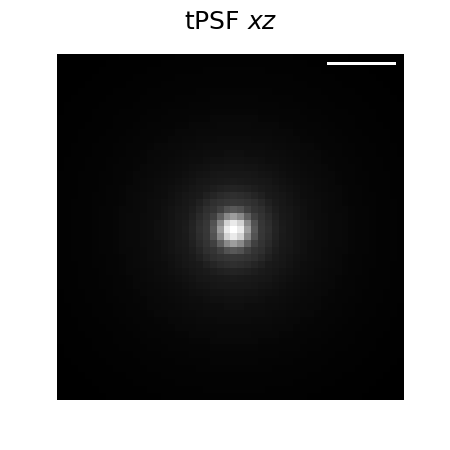

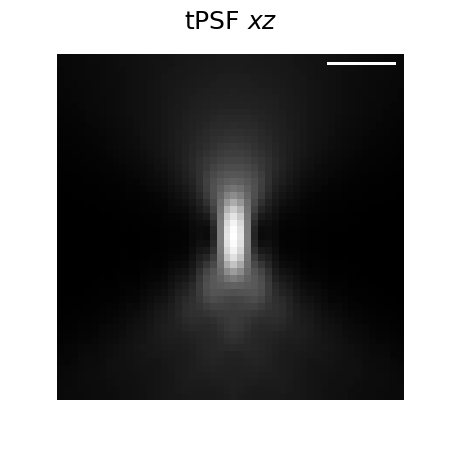

In [8]:
fig, axs = plt.subplots(1,1, figsize=(1.5, 1.5), dpi = 300)
plt.imshow(crop_to_size(my_kernel.kernel.sum(axis=0),50,50), cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.5 micron
axs.add_artist(scalebar)
plt.title("tPSF $x z$")

plt.savefig("synth_kernel_xy.svg")
plt.show()

fig, axs = plt.subplots(1,1, figsize=(1.5, 1.5), dpi = 300)
plt.imshow(crop_to_size(my_kernel.kernel.sum(axis=1),50,50), cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.5 micron
axs.add_artist(scalebar)
plt.title("tPSF $x z$")

plt.savefig("synth_kernel_xz.svg")
plt.show()


In [9]:
def lorentzian_DoG(xdata_tuple, amplitude, xo, gamma, sigma1, sigma2, offset):
    (x, y) = xdata_tuple
    lorentz = offset + amplitude / (1 + ((x - xo) / gamma)**2 + ((y - xo) / gamma)**2)
    gaussian_term_1 = np.exp(-((x - xo)**2 + (y - xo)**2) / (2 * sigma1**2))
    gaussian_term_2 = np.exp(-((x - xo)**2 + (y - xo)**2) / (2 * sigma2**2))
    return (lorentz * (gaussian_term_1 - gaussian_term_2)).ravel()

#def lorentzian_DoG(xdata_tuple, amplitude, xo, gamma, offset):
#    (x, y) = xdata_tuple
#    lorentz = offset + amplitude / (1 + ((x - xo) / gamma)**2 + ((y - xo) / gamma)**2)
#    return (lorentz).ravel()

from scipy.optimize import curve_fit
from math import sqrt
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
#fits = []
#for slice in real_PSF:
def fit_the_PSF(slice):
    #to_fit = slice
    to_fit = crop_to_size(slice,50,50)
    #to_fit /= to_fit.sum()
    #to_fit -= to_fit.min()

    x = np.linspace(0, to_fit.shape[1]-1, to_fit.shape[1])
    y = np.linspace(0, to_fit.shape[0]-1, to_fit.shape[0])
    x, y = np.meshgrid(x, y)
        
    # Initial guess parameters [amplitude, xo, yo, gamma_x, gamma_y, offset]
    initial_guess = (1, to_fit.shape[1]/2, 1, 1, 1, 0) #(1, to_fit.shape[1]/2, 1, 1, 1, 0)
    
    # Fit the 2D Lorentzian
    popt, _ = curve_fit(lorentzian_DoG, (x, y), to_fit.ravel(), p0=initial_guess, maxfev=1750000)
    
    # Generate data from the optimal parameters
    data_fitted = lorentzian_DoG((x, y), *popt)
    
    # Reshape fitted data to 2D array
    data_fitted = data_fitted.reshape(to_fit.shape[0], to_fit.shape[1])
    return data_fitted, popt

    #fits.append(data_fitted)
fits, popts = zip(*Parallel(n_jobs=-1)(delayed(fit_the_PSF)(slice) for slice in tqdm(real_PSF[crop_y//2:-20-crop_y//2])))



popts = np.array(popts)

np.save("popts.npy", popts)

#tifffile.imwrite("lorentz_psf_50nm_pix_size.tiff", np.array(fits))

lorentz_PSF_3d = np.array(fits)
plt.imshow(lorentz_PSF_3d.sum(axis=2))

  0%|          | 0/50 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x797fdcbe0a60>
Traceback (most recent call last):
  File "/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/tqdm/std.py", line 1144, in __del__
    def __del__(self):
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
lorentz_PSF_3d.shape

NameError: name 'lorentz_PSF_3d' is not defined

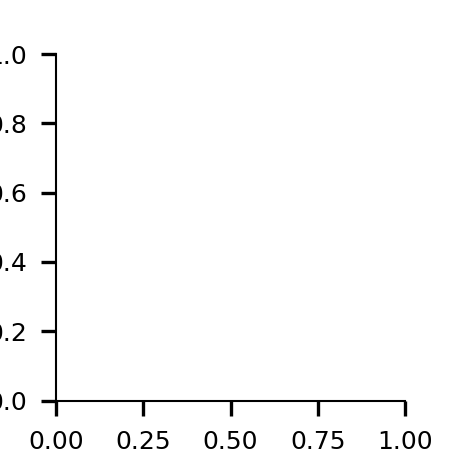

In [10]:
fig, axs = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 300)
plt.imshow(lorentz_PSF_3d[lorentz_PSF_3d.shape[0]//2], cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.5 micron
axs.add_artist(scalebar)
plt.title("ePSF $x y$")
plt.savefig("lorentz_PSF_xy.svg")
plt.show()


fig, axs = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 300)
plt.imshow(lorentz_PSF_3d.sum(axis=2), cmap="Greys_r")
plt.axis(False)
plt.title("ePSF $x z$")
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.5 micron
axs.add_artist(scalebar)
plt.savefig("lorentz_PSF_yz.svg")
plt.show()

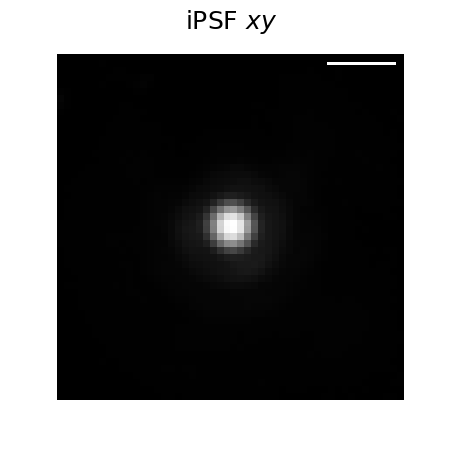

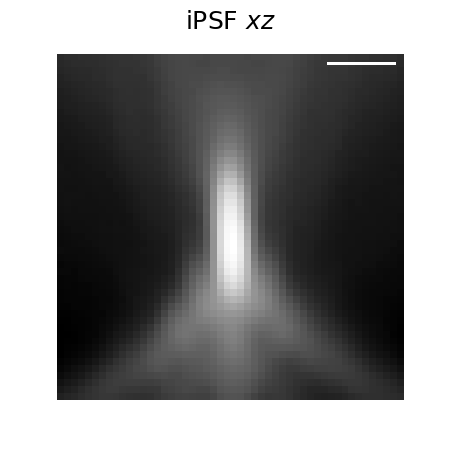

In [13]:
fig, axs = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 300)
plt.imshow(crop_to_size(real_PSF[45],50,50), cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.5 micron
axs.add_artist(scalebar)
plt.title("iPSF $x y$")
plt.savefig("real_PSF_xy.svg")
plt.show()

fig, axs = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 300)
plt.imshow(crop_to_size(real_PSF[:-20].sum(axis=1),50,50), cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.5 micron
axs.add_artist(scalebar)
plt.title("iPSF $x z$")
plt.savefig("real_PSF_xz.svg")
plt.show()

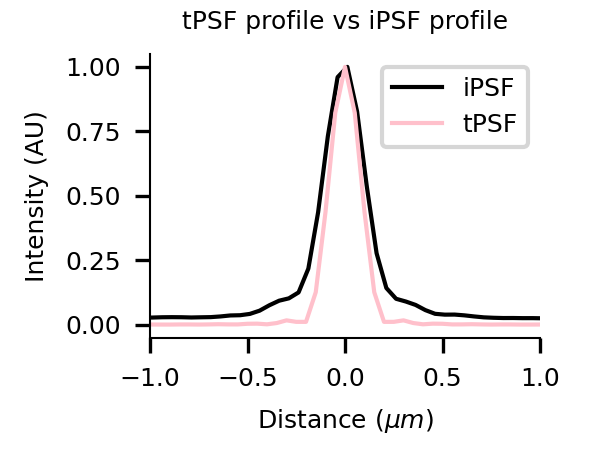

In [51]:

real_PSF_profile = real_PSF[45][104:106].mean(axis=0)[75:-75]
theoretical_PSF_profile = my_kernel.kernel[150//2][300//2,:][120:-120]
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 300)
plt.plot(np.arange(-len(real_PSF_profile)//2,len(real_PSF_profile)//2)*pix_mic_conv+0.012, real_PSF_profile[:]/real_PSF_profile.max(), label = "iPSF", color = "k")
plt.plot(
    (np.arange(-len(theoretical_PSF_profile)//2,len(theoretical_PSF_profile)//2)+1)*pix_mic_conv, theoretical_PSF_profile/theoretical_PSF_profile.max(), label = "tPSF", color = "pink"
)

plt.xlim(-1,1)
plt.title("tPSF profile vs iPSF profile")
ax.set_xlabel('Distance ($\mu m$)')
ax.set_ylabel('Intensity (AU)')
plt.legend()
fig.subplots_adjust(left=0.25, bottom = 0.25)
plt.savefig("synth_kernel_profile.svg")
plt.show()

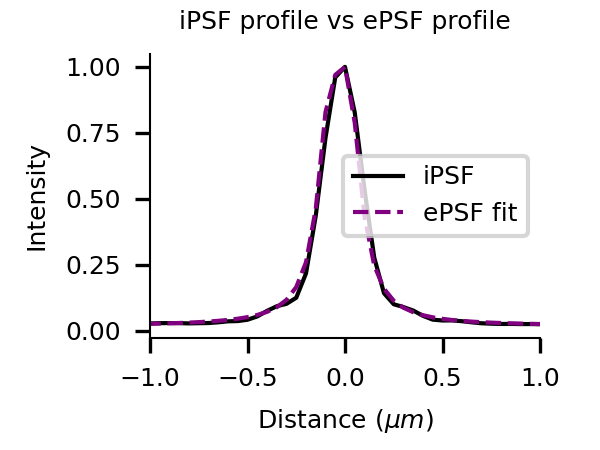

In [49]:
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 300)
plt.title("iPSF profile vs ePSF profile")
real_PSF_profile = real_PSF[45][104:106].mean(axis=0)[75:-75]
fits, popts =  fit_the_PSF(real_PSF[45])
ePSF_profile = fits[fits.shape[0]//2] #lorentz_PSF_3d[45].mean(axis=0)
plt.plot(np.arange(-len(real_PSF_profile)//2,len(real_PSF_profile)//2)*pix_mic_conv, real_PSF_profile/real_PSF_profile.max(), label= "iPSF", color = "k")
plt.plot(np.arange(-len(ePSF_profile)//2,len(ePSF_profile)//2)*pix_mic_conv, ePSF_profile[::-1]/ePSF_profile.max(), linestyle = "--", label ="ePSF fit", c = "purple")

plt.xlim(-1,1)
plt.xlabel("Distance ($\mu m$)")
ax.set_ylabel('Intensity')
plt.legend()
fig.subplots_adjust(left=0.25, bottom = 0.25)
plt.savefig("real_PSF_profile.svg")
plt.show()

In [ ]:
coords = np.argwhere(a_cell_high_res)
rng = np.random.default_rng()

conv_cells = []
for molecule_count in [100000]:
    random_coords = rng.choice(coords, molecule_count, replace=False)
    
    empty_cell = np.zeros_like(a_cell_high_res)
    for coord in random_coords:
        empty_cell[coord[0], coord[1], coord[2]] = 1


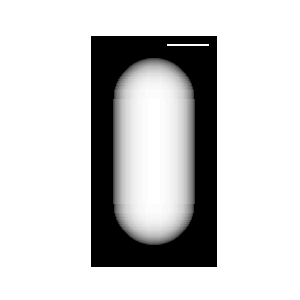

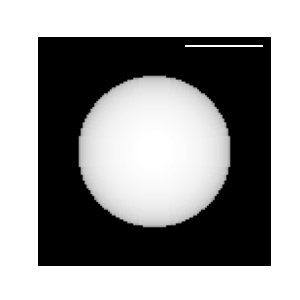

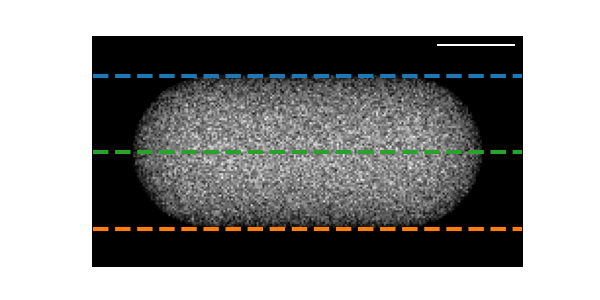

In [59]:
a_cell_high_res = np.pad(convert_to_3D(raster_cell(9/pix_mic_conv, 4/pix_mic_conv, 0)), 20)
fig, axs = plt.subplots(1,1, figsize=(1,1), dpi = 300)
plt.imshow(a_cell_high_res.sum(axis=0), cmap = "Greys_r")
plt.axis(False)
scalebar = ScaleBar(0.025/2, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.5) # 0.5 micron
axs.add_artist(scalebar)
plt.savefig("cell_xy.svg")
plt.show()

fig, axs = plt.subplots(1,1, figsize=(1,1), dpi = 300)
plt.imshow(a_cell_high_res.sum(axis=1), cmap = "Greys_r")
plt.axis(False)
scalebar = ScaleBar(0.025/2, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.5) # 0.5 micron
axs.add_artist(scalebar)
plt.savefig("cell_xz.svg")
plt.show()

fig, axs = plt.subplots(1,1, figsize=(2,1), dpi = 300)
img = empty_cell.sum(axis=2)
plt.imshow(img, cmap = "Greys_r")
plt.axis(False)
scalebar = ScaleBar(0.025/2, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.5 micron
axs.add_artist(scalebar)
plt.plot([0,img.shape[1]-1],[20, 20], linestyle = "--")
plt.plot([0,img.shape[1]-1],[img.shape[0]-20, img.shape[0]-20], linestyle = "--")
plt.plot([0,img.shape[1]-1],[img.shape[0]//2, img.shape[0]//2], linestyle = "--")

plt.savefig("cell_yz.svg")
plt.show()

(-0.5, 59.5, 99.5, -0.5)

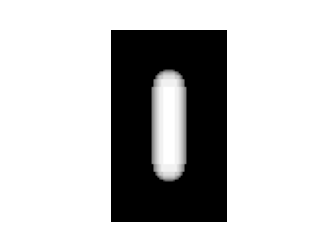

In [17]:
a_cell = convert_to_3D(np.pad(raster_cell(3/pix_mic_conv, 1/pix_mic_conv, 0), 20))
plt.imshow(a_cell.sum(axis=0), cmap = "Greys_r")
plt.axis(False)

In [18]:
conv_cell = np.array(
    [convolve_rescale(x, y, 1, False) for x, y in zip(
        a_cell.astype(float), real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2:int(df["mass_center_z"])+a_cell.shape[0]//2])
    ]
)


/tmp/ipykernel_3718/2107626391.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  a_cell.astype(float), real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2:int(df["mass_center_z"])+a_cell.shape[0]//2])


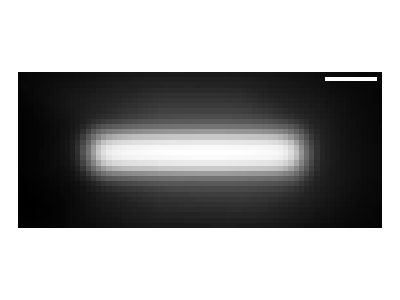

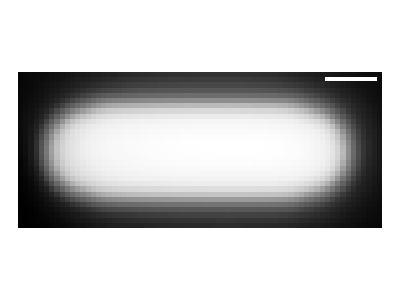

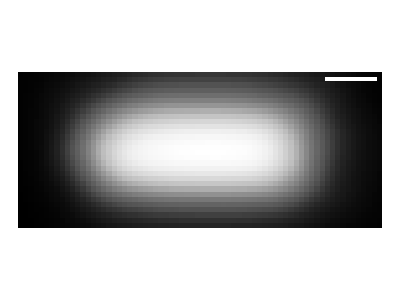

In [36]:
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 200)
plt.imshow(np.rot90(conv_cell[0][15:-15,15:-15]), cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", width_fraction=0.025, length_fraction=0.2) # 0.5 micron
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("cell_top.svg")
plt.show()
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 200)
plt.imshow(np.rot90(conv_cell[conv_cell.shape[0]//2][15:-15,15:-15]), cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white",width_fraction=0.025, length_fraction=0.2) # 0.5 micron
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("cell_mid.svg")
plt.show()
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 200)
plt.imshow(np.rot90(conv_cell[-1][15:-15,15:-15]), cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white",width_fraction=0.025, length_fraction=0.2) # 0.5 micron
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("cell_bottom.svg")
plt.show()

In [40]:
int(df["mass_center_z"])+2*a_cell.shape[0]

81

/tmp/ipykernel_3718/1336100241.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  PSF_xz_img = real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2-10:int(df["mass_center_z"])+a_cell.shape[0]//2+10].sum(axis=2)[:,90:-90]


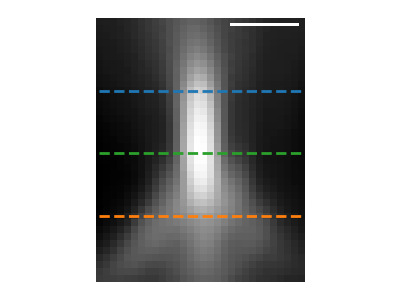

In [28]:
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 200)
PSF_xz_img = real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2-10:int(df["mass_center_z"])+a_cell.shape[0]//2+10].sum(axis=2)[:,90:-90]
img_z_centre = PSF_xz_img.shape[0]//2
plt.imshow(PSF_xz_img, cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.5) # 0.5 micron
ax.add_artist(scalebar)
plt.plot([0,PSF_xz_img.shape[1]-1], [img_z_centre-a_cell.shape[0]//2,img_z_centre-a_cell.shape[0]//2], linestyle="--")
plt.plot([0,PSF_xz_img.shape[1]-1], [img_z_centre+a_cell.shape[0]//2,img_z_centre+a_cell.shape[0]//2], linestyle="--")
plt.plot([0,PSF_xz_img.shape[1]-1], [img_z_centre,img_z_centre], linestyle="--")

plt.tight_layout()
plt.savefig("iPSF_xz.svg")
plt.show()

In [42]:
a_cell.shape[0]

18

/tmp/ipykernel_3718/3378949657.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  plt.imshow(real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2:int(df["mass_center_z"])+a_cell.shape[0]//2][0][70:-70,70:-70], cmap="Greys_r")


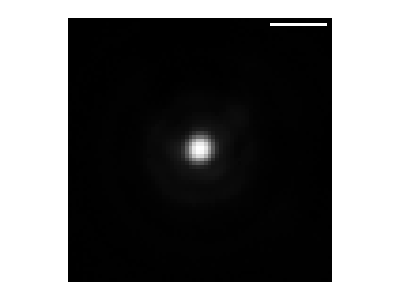

/tmp/ipykernel_3718/3378949657.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  plt.imshow(real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2:int(df["mass_center_z"])+a_cell.shape[0]//2][a_cell.shape[0]//2][70:-70,70:-70], cmap="Greys_r")


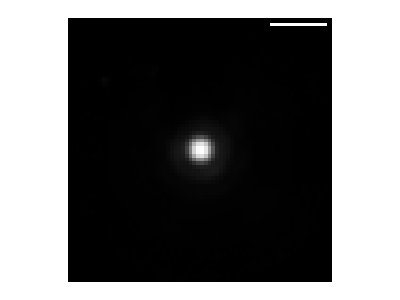

/tmp/ipykernel_3718/3378949657.py:18: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  plt.imshow(real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2:int(df["mass_center_z"])+a_cell.shape[0]//2][-1][70:-70,70:-70], cmap="Greys_r")


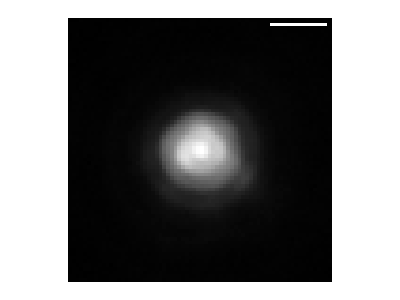

In [34]:
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 200)
plt.imshow(real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2:int(df["mass_center_z"])+a_cell.shape[0]//2][0][70:-70,70:-70], cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.75 micron
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("PSF_top.svg")
plt.show()
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 200)
plt.imshow(real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2:int(df["mass_center_z"])+a_cell.shape[0]//2][a_cell.shape[0]//2][70:-70,70:-70], cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.2 micron
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("PSF_mid.svg")
plt.show()
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 200)
plt.imshow(real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2:int(df["mass_center_z"])+a_cell.shape[0]//2][-1][70:-70,70:-70], cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.2 micron
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("PSF_bottom.svg")
plt.show()

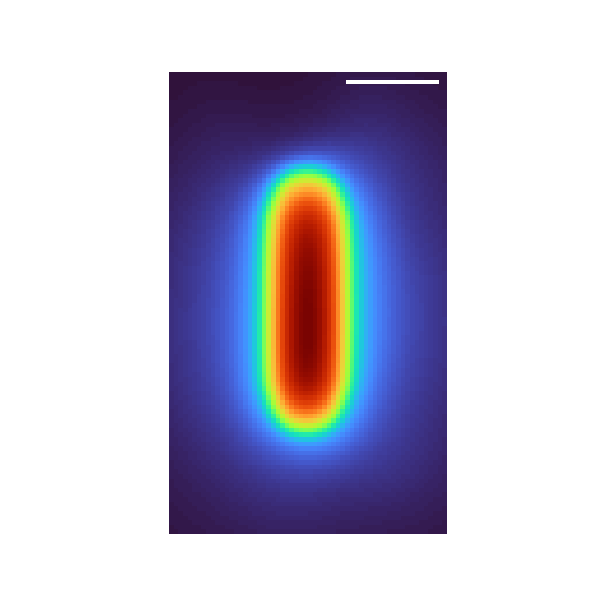

In [76]:
fig, axs = plt.subplots(1,1, figsize=(2,2), dpi = 300)
plt.imshow(conv_cell.sum(axis=0), cmap="turbo")
plt.axis(False)
scalebar = ScaleBar(0.05, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.5) # 1 micron
axs.add_artist(scalebar)
plt.savefig("single_cell_turbo.svg")

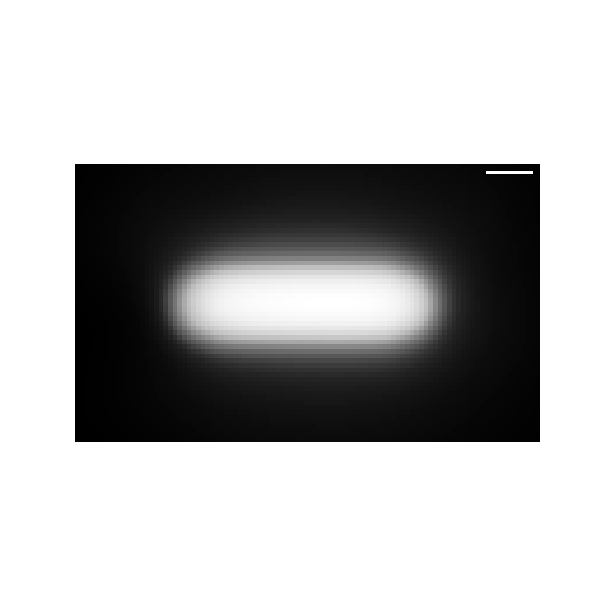

In [41]:
fig, axs = plt.subplots(1,1, figsize=(2,2), dpi = 300)
plt.imshow(np.rot90(conv_cell.sum(axis=0)), cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(0.05, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.15) # 0.5 micron
axs.add_artist(scalebar)
plt.savefig("single_cell_greys.svg")